<a href="https://colab.research.google.com/github/daorhe2272/analisis_de_datos_I/blob/main/Taller_2_An%C3%A1lisis_de_Datos_I.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Taller 2: Comparte tu análisis univariado**

Para consultar el problema y la pregunta SMART que se trata de responder, [favor ver este enlace.](https://github.com/daorhe2272/analisis_de_datos_I/blob/main/taller_1.ipynb)

El siguiente set de datos corresponde a la rotación por producto de los últimos 3 meses de una empresa que comercializa productos de consumo masivo no perecederos:

In [1]:
# Primero cargamos los datos
import pandas as pd

data_url = "https://raw.githubusercontent.com/daorhe2272/analisis_de_datos_I/main/query_results.json"

df = pd.read_json(data_url)
df.head()

,Activo,Categorias,_id,Codigo,Descripcion,Marca,Unidad_venta,Stock,Costo,Precio_base,Rotacion_actual,Rotacion_mes,Rotacion_bimestre,Rotacion_trimestre,Comprado,Fecha_compra,iva,Descripcion_full
0,True,"[Papel regalos, seda, crepé, craft]",63e570ea6aa0ed10c8a8340b,1375,PAPEL CELOFAN AMARILLO 96X100,AFA DIST,UNIDAD,499,314,440,0,530,660,1210,4000,20231204,19,Papel celofan amarillo 96x099
1,False,[Otros cacharrería],63e570ea6aa0ed10c8a833e3,1003,INGRESO PARA TERCEROS (22937),BELLEZA,UNID.,0,1,1380000,0,0,0,0,0,20200210,0,Ingreso para terceros
2,False,[Cuadernos y agendas],63e570ea6aa0ed10c8a833ed,7861084254023,CUAD.LINEA AZUL 85-100-1 STIKER,A&C ESCO,UNID.,0,1450,1800,0,4,4,4,300,20190215,0,Cuaderno Línea Azul con stickers argollado peq...
3,True,[Bombillos],63e570ea6aa0ed10c8a83467,7703255298989,BOMBILLO NALPILUX LED 5W,PANASONI,UNIDAD,130,2285,2800,22,66,166,166,100,20240822,19,Bombillo Nalpilux led 5w
4,False,[Enjuages bucales],63e570ea6aa0ed10c8a83487,037000956662,ENJ.CREST SCOPE OUTLAST X500ML,PREBEL,UNIDAD,0,10042,11520,0,0,0,0,3,20230118,19,Enjuague bucal crest scope outlast de 500 ml


El objetivo principal de este taller es preparar el terreno para la construcción de un modelo predictivo que permita estimar la demanda de cada producto en el mes siguiente. Para limitar la complejidad del modelo, vamos a obviar cambios en los costos y precios de venta por producto, así como el efecto que la marca del producto pueda tener sobre cambios estacionales.

In [2]:
# Eliminamos las columnas que no necesitaremos en este análisis:
columns_to_drop = ["Activo","Marca","Costo","Rotacion_actual","Comprado","iva"]
df = df.drop(columns=columns_to_drop)
df.head()

,Categorias,_id,Codigo,Descripcion,Unidad_venta,Stock,Precio_base,Rotacion_mes,Rotacion_bimestre,Rotacion_trimestre,Fecha_compra,Descripcion_full
0,"[Papel regalos, seda, crepé, craft]",63e570ea6aa0ed10c8a8340b,1375,PAPEL CELOFAN AMARILLO 96X100,UNIDAD,499,440,530,660,1210,20231204,Papel celofan amarillo 96x099
1,[Otros cacharrería],63e570ea6aa0ed10c8a833e3,1003,INGRESO PARA TERCEROS (22937),UNID.,0,1380000,0,0,0,20200210,Ingreso para terceros
2,[Cuadernos y agendas],63e570ea6aa0ed10c8a833ed,7861084254023,CUAD.LINEA AZUL 85-100-1 STIKER,UNID.,0,1800,4,4,4,20190215,Cuaderno Línea Azul con stickers argollado peq...
3,[Bombillos],63e570ea6aa0ed10c8a83467,7703255298989,BOMBILLO NALPILUX LED 5W,UNIDAD,130,2800,66,166,166,20240822,Bombillo Nalpilux led 5w
4,[Enjuages bucales],63e570ea6aa0ed10c8a83487,037000956662,ENJ.CREST SCOPE OUTLAST X500ML,UNIDAD,0,11520,0,0,0,20230118,Enjuague bucal crest scope outlast de 500 ml


In [3]:
# Revisamos si hay valores problemáticos
print("Valores nulos por columna:\n")
print(df.isnull().sum())


Valores nulos por columna:

Categorias            0
_id                   0
Codigo                0
Descripcion           0
Unidad_venta          0
Stock                 0
Precio_base           0
Rotacion_mes          0
Rotacion_bimestre     0
Rotacion_trimestre    0
Fecha_compra          0
Descripcion_full      0
dtype: int64


In [4]:
# Ahora vamos a ignorar los productos cuya última compra fue mayor a 12 meses,
# pues su venta no cumplió las expectativas y no habrá recompra
# ó la información corresponde a items en desuso

# Primero eliminamos las filas cuyo formato de fecha esté errado
df["Fecha_compra"] = df["Fecha_compra"].astype(str)
df["Fecha_compra"] = df[df["Fecha_compra"].str.len() == 8]["Fecha_compra"]

df = df.dropna()
df = df[df['Fecha_compra'].str.startswith('20')]

# Ahora removemos los productos comprados por última vez hace más de 1 año
from datetime import datetime, timedelta

df['Fecha_compra'] = pd.to_datetime(df['Fecha_compra'].astype(str), format='%Y%m%d')
now = datetime.now()
time_limit = now - timedelta(days=365)
df = df[df["Fecha_compra"] > time_limit]

df = df.reset_index(drop=True)
df.head()

<ipython-input-4-23b96540b450>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Fecha_compra'] = pd.to_datetime(df['Fecha_compra'].astype(str), format='%Y%m%d')


,Categorias,_id,Codigo,Descripcion,Unidad_venta,Stock,Precio_base,Rotacion_mes,Rotacion_bimestre,Rotacion_trimestre,Fecha_compra,Descripcion_full
0,"[Papel regalos, seda, crepé, craft]",63e570ea6aa0ed10c8a8340b,1375,PAPEL CELOFAN AMARILLO 96X100,UNIDAD,499,440,530,660,1210,2023-12-04,Papel celofan amarillo 96x099
1,[Bombillos],63e570ea6aa0ed10c8a83467,7703255298989,BOMBILLO NALPILUX LED 5W,UNIDAD,130,2800,66,166,166,2024-08-22,Bombillo Nalpilux led 5w
2,[Deshodorantes],63e570eb6aa0ed10c8a834dd,7702044246859,DST.ELIZAB.CREM.X135G.X2 P/ESP.,UNIDAD,114,18500,15,37,52,2024-07-29,Desodorante en crema Elizabeth Arden de 135 gr...
3,[Protección solar],63e570eb6aa0ed10c8a8350d,7702044272186,BLOQ.NUDE SPF 50 X50ML FAC.COLOR,UNIDAD,26,39300,10,23,30,2024-09-03,Bloqueador Nude crema facial con color SPF 50 ...
4,[Protección solar],63e570eb6aa0ed10c8a8351f,7702044280587,BLOQ.NUDE SPF50 X12UN.X10ML.COLOR.FAC.,DISPLEY,68,32400,46,93,119,2024-09-03,BLoqueador Nude crema facial con color SPF 50 ...


In [5]:
# Finalmente eliminamos los productos cuya rotación trimestral acumulada es cero
df = df[df['Rotacion_trimestre'] != 0]
df = df.reset_index(drop=True)

# Lo cual nos deja un dataset de poco más de 5.000 productos
# aunque es de notar que aún queda un número importante de productos
# con una rotación trimestral significativamente baja
len(df)

5132

In [6]:
# Ahora vamos a convertir los datos de rotación acumulada en rotación mensual:
df["Rotacion_trimestre"] = df["Rotacion_trimestre"] - df["Rotacion_bimestre"]
df["Rotacion_bimestre"] = df["Rotacion_bimestre"] - df["Rotacion_mes"]

In [7]:
# ...y renombramos las columnas para cada mes
from dateutil.relativedelta import relativedelta

mes_1 = (now - relativedelta(months=1)).strftime("%B")
mes_2 = (now - relativedelta(months=2)).strftime("%B")
mes_3 = (now - relativedelta(months=3)).strftime("%B")

df = df.rename(columns={
    "Rotacion_mes": mes_1,
    "Rotacion_bimestre": mes_2,
    "Rotacion_trimestre": mes_3
})

df.head()

,Categorias,_id,Codigo,Descripcion,Unidad_venta,Stock,Precio_base,August,July,June,Fecha_compra,Descripcion_full
0,"[Papel regalos, seda, crepé, craft]",63e570ea6aa0ed10c8a8340b,1375,PAPEL CELOFAN AMARILLO 96X100,UNIDAD,499,440,530,130,550,2023-12-04,Papel celofan amarillo 96x099
1,[Bombillos],63e570ea6aa0ed10c8a83467,7703255298989,BOMBILLO NALPILUX LED 5W,UNIDAD,130,2800,66,100,0,2024-08-22,Bombillo Nalpilux led 5w
2,[Deshodorantes],63e570eb6aa0ed10c8a834dd,7702044246859,DST.ELIZAB.CREM.X135G.X2 P/ESP.,UNIDAD,114,18500,15,22,15,2024-07-29,Desodorante en crema Elizabeth Arden de 135 gr...
3,[Protección solar],63e570eb6aa0ed10c8a8350d,7702044272186,BLOQ.NUDE SPF 50 X50ML FAC.COLOR,UNIDAD,26,39300,10,13,7,2024-09-03,Bloqueador Nude crema facial con color SPF 50 ...
4,[Protección solar],63e570eb6aa0ed10c8a8351f,7702044280587,BLOQ.NUDE SPF50 X12UN.X10ML.COLOR.FAC.,DISPLEY,68,32400,46,47,26,2024-09-03,BLoqueador Nude crema facial con color SPF 50 ...


Habiendo terminado la recolección, limpieza y transformación de los datos, podemos continuar con nuestro análisis exploratorio.

NOTA: la columna Categorías está aún en forma de listas y necesita ser desestructurada. Sin embargo, para este taller no haré uso de esta variable.

# **ANÁLISIS UNIVARIADO**

Queremos pronosticar las ventas del mes siguiente para cada producto, razón por la cual, en este caso, las columnas más importantes corresponden a los datos de las ventas de mayo, junio y julio. Como es bien sabido, la variable más significativa para el análisis y pronóstico de series de tiempo es el promedio de los datos inmediatamente anteriores. En la gran mayoría de estos modelos, el valor de la media móvil puede perfectamente "explicar", por así decirlo, más del 80 o 90 por ciento de las fluctuaciones de una variable en el tiempo.

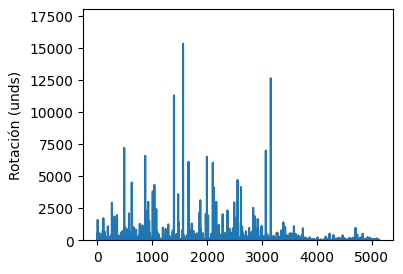

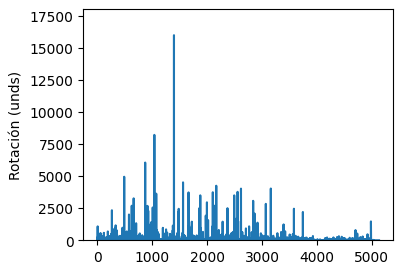

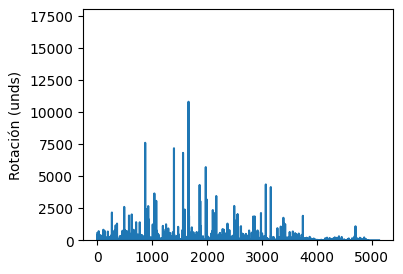

In [9]:
# Veamos rápidamente cómo están estructurados los datos con un histograma
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 3))
plt.plot(df.index, df['August'])
plt.ylabel("Rotación (unds)")
plt.ylim(0, 18000)
plt.show()

plt.figure(figsize=(4, 3))
plt.plot(df.index, df['July'])
plt.ylabel("Rotación (unds)")
plt.ylim(0, 18000)
plt.show()

plt.figure(figsize=(4, 3))
plt.plot(df.index, df['June'])
plt.ylabel("Rotación (unds)")
plt.ylim(0, 18000)
plt.show()

Lo que nos muestran las 3 gráficas de barras es que la rotación de los productos en inventario es extremadamente variable. Algunos de ellos llegan a venderse por miles, mientras la gran mayoría se vende por docenas o centenas.

In [10]:
# Estos fueron los productos con mayor rotación en julio:
df.sort_values(by='July', ascending=False).head(8)

,Categorias,_id,Codigo,Descripcion,Unidad_venta,Stock,Precio_base,August,July,June,Fecha_compra,Descripcion_full
1397,[Algodones],63e5710f6aa0ed10c8a85101,7702208100058,ALG.HIGIET.X 5 GRS.,UNIDAD,13545,500,11293,15981,7171,2024-08-09,Algodón Higietex de 5 gr
1040,[Otros droguería general],63e571036aa0ed10c8a846bf,7707233050590,RECIPIENTE ORINA,UNIDAD,12820,300,4320,8213,3649,2024-08-12,Recipiente para orina
873,[Jeringas],63e570ff6aa0ed10c8a843b9,7702037510981,JERIN.PRECIS.ETER.5 LARGA,UNIDAD,2239,210,6583,6056,7595,2024-08-05,Jeringa Precisión Eterna de 5 ml
491,[Sobres],63e570fa6aa0ed10c8a83fad,0049,SOBRE BLANCO RECT.PNO DIEZMOS,UNIDAD,5800,50,7200,4950,2600,2024-05-16,Sobre blanco rectangular tipo diezmo
1562,[Alcoholes],63e571196aa0ed10c8a85855,7705137100106,ALCOHOL OSA PLAST.X345,UNIDAD,4891,3090,15319,4513,6811,2024-08-28,Alcoghol Osa botella plástica de 345 ml
2167,"[Papel regalos, seda, crepé, craft]",63e5711f6aa0ed10c8a85d77,0311,PAPEL PERIOD.PLIEGOS,UNIDAD,1507,170,3000,4250,3450,2024-06-27,Papel periódico en pliegos
3160,"[Ungüentos y pomadas, Otros droguería general]",63e571356aa0ed10c8a86fab,7707321120099,UNG.MENTOLIN X 5 GRS.,UNIDAD,15544,1090,12625,4032,4146,2024-08-05,Ungüento Mentolin de 5 gr
2617,"[Papel regalos, seda, crepé, craft]",63e571276aa0ed10c8a863b1,0323,PAPEL SEDA BLANCO,UNIDAD,23255,130,4150,4025,1100,2024-08-13,Papel seda blanco


La gran mayoría de estos productos de muy alta rotación logran explicarse por su bajo costo, por lo que convendría analizar la distribución de las ventas mensuales por producto en pesos.

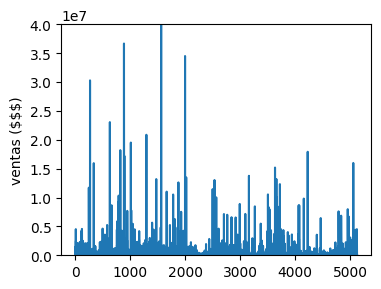

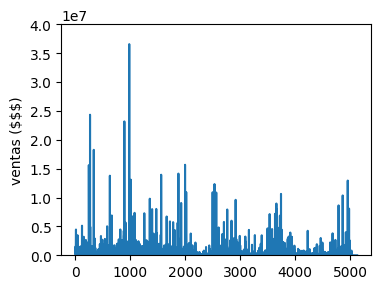

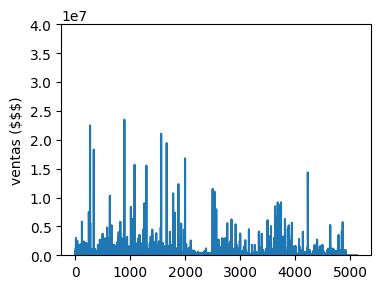

In [11]:
# Histogramas de ventas en pesos
df['August_sales'] = df['August'] * df['Precio_base']
df['July_sales'] = df['July'] * df['Precio_base']
df['June_sales'] = df['June'] * df['Precio_base']

plt.figure(figsize=(4, 3))
plt.plot(df.index, df['August_sales'])
plt.ylabel("ventas ($$$)")
plt.ylim(0, 40000000)
plt.show()

plt.figure(figsize=(4, 3))
plt.plot(df.index, df['July_sales'])
plt.ylabel("ventas ($$$)")
plt.ylim(0, 40000000)
plt.show()

plt.figure(figsize=(4, 3))
plt.plot(df.index, df['June_sales'])
plt.ylabel("ventas ($$$)")
plt.ylim(0, 40000000)
plt.show()

In [12]:
print(df[['August','July', 'June']].describe())

             August          July          June
count   5132.000000   5132.000000   5132.000000
mean      84.298714     73.157833     65.093920
std      465.742707    384.626124    336.103132
min        0.000000    -10.000000     -4.000000
25%        2.000000      1.000000      1.000000
50%       10.000000      9.000000      7.000000
75%       38.000000     32.250000     29.000000
max    15319.000000  15981.000000  10795.000000


Ya sean medidas en pesos o unidades, podemos apreciar una gran variabilidad en la rotación por producto. La estadística descriptiva para los 3 últimos meses lo muestra igualmente en sus valores mínimos y máximos. También podemos observar que el último cuartil concentra el grueso de la rotación por producto en unidades.
De lo anterior, **podemos concluir que** hay diferencias importantes entre productos y no conviene hacer un pronóstico agrupado, sino más bien por una unidad de medida más específica, ya sea por tipo de producto o por el producto en sí mismo.

In [13]:
# Veamos la rotación por mes de al menos 15 productos
df.head(15)[["Descripcion","August","July","June"]]

,Descripcion,August,July,June
0,PAPEL CELOFAN AMARILLO 96X100,530,130,550
1,BOMBILLO NALPILUX LED 5W,66,100,0
2,DST.ELIZAB.CREM.X135G.X2 P/ESP.,15,22,15
3,BLOQ.NUDE SPF 50 X50ML FAC.COLOR,10,13,7
4,BLOQ.NUDE SPF50 X12UN.X10ML.COLOR.FAC.,46,47,26
5,ACEITE 3 EN 1 GOTERO X 30 ML.,135,101,83
6,JARABE PASSIFLORA ELIX.X120ML,9,12,18
7,MARC.SHARPIE AZUL P.FINA,145,68,84
8,MARC.SHARPIE NEGRO P.FINA,1587,1083,449
9,KILOMETRICO 100 AZUL X12UN.07 PUN-FINA,40,113,25


En efecto, aunque se aprecia algún grado de variabilidad, hay mayor similitud entre la rotación mensual de un mismo producto que entre la rotación de productos diferentes. Por ejemplo, el marcador Sharpie tiende a mantener una alta rotación cada mes, mientras la crema Vitú logra pocas ventas mes a mes.

In [14]:
# Matrices de correlación
correlation_matrix = df[['August','July', 'June']].corr()
print(correlation_matrix)

          August      July      June
August  1.000000  0.828904  0.825879
July    0.828904  1.000000  0.797938
June    0.825879  0.797938  1.000000


In [15]:
correlation_matrix = df[['August_sales','July_sales', 'June_sales']].corr()
print(correlation_matrix)

              August_sales  July_sales  June_sales
August_sales      1.000000    0.677595    0.712223
July_sales        0.677595    1.000000    0.729508
June_sales        0.712223    0.729508    1.000000


Así mismo, las matrices de correlación entre los tres meses medidos nos muestran que:

1.   La rotación de los otros meses explica más de un 79% de la rotación de los demás.
2.   Las ventas de meses anteriores explican más de un 72% de la venta de otros meses.

# **Conclusiones**



*   En el modelado de las series de tiempo, los valores previos en la serie explican la mayor parte de la estadística. La clave consiste en encontrar variables capaces de explicar la variabilidad restante.
*   La diferencia estadística de rotación entre un producto y otro es muy amplia, por lo que es posible que el pronóstico deba hacerse para cada producto según su rotación en meses pasados. Cabe la posibilidad de agrupar los productos por categoría para así estimar su variabilidad estacional.
*  Menos del 25% de los productos en el inventario son de rotación alta, por lo que conviene analizar si es necesario hacer un pronóstico para todas las referencias en el catálogo, o si es mejor concentrar los esfuerzos en crear un modelo para aquellos que tienen una mayor rotación.

\- FIN -